In [68]:
import pandas as pd

# numeric functions
import numpy as np
from scipy import stats
from math import ceil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modelling
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures

In [69]:
df_train = pd.read_csv('../train.csv',index_col='Id')
df_test = pd.read_csv('../test.csv',index_col='Id')

# ids of full training dataset
id_train = df_train.index

# ids of full test dataset
id_test = df_test.index

# combine train and test datas in to one dataframe
df_all = pd.concat([df_train,df_test])
df_all.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [70]:
print('train.shape=', df_train.shape, ', test.shape=', df_test.shape)

train.shape= (1460, 80) , test.shape= (1459, 79)


In [71]:
cols_with_na = df_all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


## Meaningful NaN Values

In [72]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_all[col].fillna('None',inplace=True)
    
#GarageYrBlt nans: no garage. Fill with property YearBuilt.
#(more appropriate than 0, which would be ~2000 away from all other values)
df_all.loc[df_all.GarageYrBlt.isnull(),'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(),'YearBuilt']

#No masonry veneer - fill area with 0
df_all.MasVnrArea.fillna(0,inplace=True)

#No basement - fill areas/counts with 0    
df_all.BsmtFullBath.fillna(0,inplace=True)
df_all.BsmtHalfBath.fillna(0,inplace=True)
df_all.BsmtFinSF1.fillna(0,inplace=True)
df_all.BsmtFinSF2.fillna(0,inplace=True)
df_all.BsmtUnfSF.fillna(0,inplace=True)
df_all.TotalBsmtSF.fillna(0,inplace=True)

#No garage - fill areas/counts with 0
df_all.GarageArea.fillna(0,inplace=True)
df_all.GarageCars.fillna(0,inplace=True)

## LotFrontage NaN Values

In [73]:
# function to normalise a column of values to lie between 0 and 1
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

----------------
Intercept: 93.20848325398028
----------------head(10)
LotArea             71.475879
RoofMatl_ClyTile    49.396968
1stFlrSF            27.547832
PoolArea            26.905146
RoofStyle_Shed      25.874524
GrLivArea           22.148975
Foundation_Wood     20.075497
LotShape_IR3        17.721471
GarageArea          17.536239
BldgType_2fmCon     16.123235
dtype: float64
----------------tail(10)
Utilities_AllPub      -11.610027
BldgType_TwnhsE       -12.070870
BsmtCond_Po           -12.151678
Exterior1st_CemntBd   -14.553347
PoolQC_Fa             -14.706527
RoofMatl_WdShake      -15.579127
BldgType_Twnhs        -17.924473
RoofMatl_WdShngl      -18.222015
GarageYrBlt           -21.591319
LotConfig_CulDSac     -23.428742
dtype: float64
----------------
R2: 0.6889229361774905
----------------


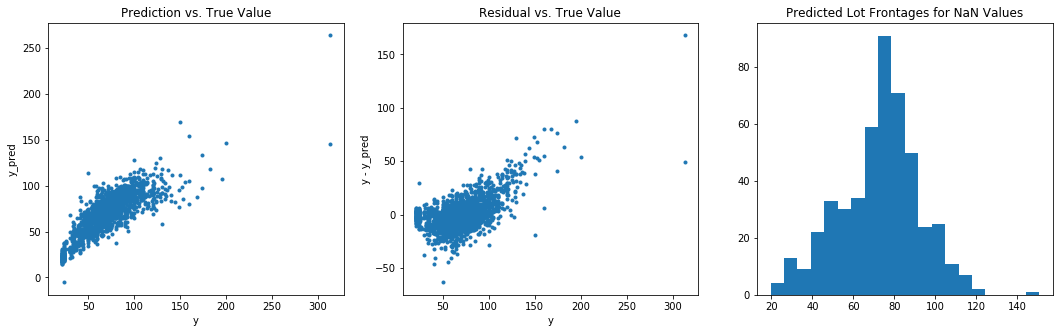

In [74]:
#LotFrontage
# fill nan values using a linear regressor

# convert categoricals to dummies, exclude SalePrice from model
df_frontage = pd.get_dummies(df_all.drop('SalePrice',axis=1))

# normalise columns to 0-1
for col in df_frontage.drop('LotFrontage',axis=1).columns:
    df_frontage[col] = scale_minmax(df_frontage[col])

lf_train = df_frontage.dropna()
lf_train_y = lf_train.LotFrontage
lf_train_X = lf_train.drop('LotFrontage',axis=1)  

# fit model
lr = Ridge()
lr.fit(lf_train_X, lf_train_y)

# check model results
lr_coefs = pd.Series(lr.coef_,index=lf_train_X.columns)

print('----------------')
print('Intercept:',lr.intercept_)
print('----------------head(10)')
print(lr_coefs.sort_values(ascending=False).head(10))
print('----------------tail(10)')
print(lr_coefs.sort_values(ascending=False).tail(10))
print('----------------')
print('R2:',lr.score(lf_train_X,lf_train_y))
print('----------------')

lf_pred_y = lr.predict(lf_train_X)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(lf_train_y,lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y_pred');
plt.title('Prediction vs. True Value')

plt.subplot(1,3,2)
plt.plot(lf_train_y, lf_train_y-lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('Residual vs. True Value')


# fill na values using model predictions
nan_frontage = df_all.LotFrontage.isnull()
X = df_frontage[nan_frontage].drop('LotFrontage',axis=1)
y = lr.predict(X)

plt.subplot(1,3,3)
plt.hist(y,bins=20)
plt.title('Predicted Lot Frontages for NaN Values')

# fill nan values
df_all.loc[nan_frontage,'LotFrontage'] = y

## Remaining NaNs

In [75]:
cols_with_na = df_all.drop('SalePrice', axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False).to_string())

MSZoning       4
Utilities      2
Functional     2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
Electrical     1


In [76]:
rows_with_na = df_all.drop('SalePrice',axis=1).isnull().sum(axis=1)
rows_with_na = rows_with_na[rows_with_na>0]
print(rows_with_na.sort_values(ascending=False).to_string())

Id
2217    2
2152    2
1916    2
2905    1
2490    1
2474    1
2251    1
1946    1
1556    1
1380    1


In [77]:
# fill remaining nans with mode in that column
for col in cols_with_na.index:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)
# check nans    
df_all.drop('SalePrice', axis=1).isnull().sum().max() 

0

In [78]:
# Now no more NaN values
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29

## Basement Finish Types

In [79]:
# create separate columns for area of each possible
# basement finish type
bsmt_fin_cols = ['BsmtGLQ','BsmtALQ','BsmtBLQ',
                 'BsmtRec','BsmtLwQ']

for col in bsmt_fin_cols:
    # initialise as columns of zeros
    df_all[col+'SF'] = 0

# fill remaining finish type columns
for row in df_all.index:
    fin1 = df_all.loc[row,'BsmtFinType1']
    if (fin1!='None') and (fin1!='Unf'):
        # add area (SF) to appropriate column
        df_all.loc[row,'Bsmt'+fin1+'SF'] += df_all.loc[row,'BsmtFinSF1']
        
    fin2 = df_all.loc[row,'BsmtFinType2']
    if (fin2!='None') and (fin2!='Unf'):
        df_all.loc[row,'Bsmt'+fin2+'SF'] += df_all.loc[row,'BsmtFinSF2']


# remove initial BsmtFin columns
df_all.drop(['BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2'], axis=1, inplace=True)

# already have BsmtUnf column in dataset
bsmt_fin_cols.append('BsmtUnf')

# also create features representing the fraction of the basement that is each finish type
for col in bsmt_fin_cols:
    df_all[col+'Frac'] = df_all[col+'SF']/df_all['TotalBsmtSF']
    # replace any nans with zero (for properties without a basement)
    df_all[col+'Frac'].fillna(0,inplace=True)
    
# check nans    
df_all.drop('SalePrice', axis=1).isnull().sum().max() 